In [1]:
# Packages importieren
import pickle
import joblib

from tqdm.notebook import tqdm
from tqdm_joblib import tqdm_joblib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score, precision_score,roc_auc_score, roc_curve, auc, f1_score, precision_recall_curve, brier_score_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, validation_curve, learning_curve
from sklearn.calibration import CalibratedClassifierCV

C:\Users\haihu\AppData\Roaming\Python\Python313\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Datenabrufen
X_train = pd.read_csv("../../Resampling/X_train.csv", index_col=0)
X_test = pd.read_csv("../../Resampling/X_test.csv", index_col=0)
X_val = pd.read_csv("../../Resampling/X_val.csv", index_col=0)

X_train_stm = pd.read_csv("../../Resampling/X_train_stm.csv", index_col=0)
X_test_stm = pd.read_csv("../../Resampling/X_test_stm.csv", index_col=0)
X_val_stm = pd.read_csv("../../Resampling/X_val_stm.csv", index_col=0)

y_train = pd.read_csv("../../Resampling/y_train.csv", index_col=0)
y_train_stm = pd.read_csv("../../Resampling/y_train_stm.csv", index_col=0)

y_test = pd.read_csv("../../Resampling/y_test.csv", index_col=0)
y_val = pd.read_csv("../../Resampling/y_val.csv", index_col=0)

print("Alle Datensätze wurden importiert.")

Alle Datensätze wurden importiert.


## E_MT_RF_1: Random Forest mit resampeltem Datensatz

In [3]:
rf = RandomForestClassifier(bootstrap=True, random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [375, 400, 450, 500],
    'criterion': ['entropy', 'gini', 'log_loss'],
    'min_samples_split': [15, 25, 35, 45],
    'min_samples_leaf': [5, 10, 15, 20, 30],
    'max_depth': [15, 20, 30, 35, 45],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [200, 400, 800, 1000, 1200],
    'oob_score': [True, False]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

In [4]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    scoring=scoring,
    refit="f1",
    cv=cv,
    verbose=3,
    n_jobs=-1,
    error_score='raise'
)

random_search.fit(X_train_stm, np.ravel(y_train_stm))
results = random_search.cv_results_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [5]:
print("Beste zufällige Params: ", random_search.best_params_)

Beste zufällige Params:  {'oob_score': False, 'n_estimators': 400, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_leaf_nodes': 1200, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}


In [7]:
# Feinssuche mit GridSearch
param_grid2 = {
    'criterion': ['gini'],
    'oob_score': [True, False],
    'max_depth': [20,25,30],
    'max_features': ['sqrt'],
    'max_leaf_nodes': [1100,1200,1300],
    'n_estimators': [375,400,425,450],
    'min_samples_split': [10,15,20],
    'min_samples_leaf': [5,10,15],
}

grid_search2 = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid2,
    cv=cv,
    n_jobs=-1,
    scoring=scoring,
    refit="f1",
    verbose=10,
    error_score='raise'
)

grid_search2.fit(X_train_stm, np.ravel(y_train_stm))

print("Beste Parameter:", grid_search2.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Beste Parameter: {'oob_score': True, 'n_estimators': 425, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_leaf_nodes': 1300, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}


In [8]:
# Finale Modell
rf_model = RandomForestClassifier(
    n_estimators=425,
    criterion='gini',
    min_samples_split=10,
    min_samples_leaf=5,
    max_depth=20,
    max_features='sqrt',
    max_leaf_nodes=1300,
    oob_score=True,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_stm, np.ravel(y_train_stm))

,n_estimators,425
,criterion,'gini'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,1300
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [9]:
y_pred = rf_model.predict(X_val_stm)

print(classification_report(np.ravel(y_val), y_pred))
print("Confusion Matrix:\n", confusion_matrix(np.ravel(y_val), y_pred))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     21833
           1       0.32      0.69      0.44      3535

    accuracy                           0.75     25368
   macro avg       0.63      0.73      0.64     25368
weighted avg       0.85      0.75      0.79     25368

Confusion Matrix:
 [[16674  5159]
 [ 1093  2442]]


In [14]:
y_pred_test = rf_model.predict(X_test_stm)
y_probs_test = rf_model.predict_proba(X_test_stm)[:,1]
auc_score = roc_auc_score(np.ravel(y_test), y_probs_test)
print(f"AUC-ROC: {auc_score:.4f}")
print(classification_report(np.ravel(y_test), y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(np.ravel(y_test), y_pred_test))

AUC-ROC: 0.8109
              precision    recall  f1-score   support

           0       0.94      0.76      0.84     43667
           1       0.32      0.69      0.44      7069

    accuracy                           0.75     50736
   macro avg       0.63      0.73      0.64     50736
weighted avg       0.85      0.75      0.78     50736

Confusion Matrix:
 [[33236 10431]
 [ 2157  4912]]


## E_MT_RF_2: Random Forest mit originärem Datensatz und angepasster 'class_weight'

In [15]:
# RandomizedSearch
rf = RandomForestClassifier(bootstrap=True, random_state=42, n_jobs=-1)

param_grid3 = {
    'n_estimators': [375, 400, 450, 500],
    'criterion': ['entropy', 'gini', 'log_loss'],
    'min_samples_split': [15, 25, 35, 45],
    'min_samples_leaf': [5, 10, 15, 20, 30],
    'max_depth': [15, 20, 30, 35, 45],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [400, 800, 1000, 1200, 1300],
    'oob_score': [True, False],
    'class_weight': [{0:1, 1:4}, {0:1, 1:5}, {0:1,1:6}, {0:0.8,1:3}, {0:1,1:8}]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

r_search3 = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid3,
    cv=cv,
    n_jobs=-1,
    scoring=scoring,
    refit="f1",
    verbose=10,
    error_score='raise'
)

r_search3.fit(X_train, np.ravel(y_train))

print("Beste Parameter:", r_search3.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Beste Parameter: {'oob_score': False, 'n_estimators': 375, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_leaf_nodes': 1300, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'log_loss', 'class_weight': {0: 0.8, 1: 3}}


In [16]:
# RandomizedSearch 2
rf = RandomForestClassifier(bootstrap=True, random_state=42, n_jobs=-1)

param_grid4 = {
    'n_estimators': [300, 325, 350, 375, 400],
    'criterion': ['entropy', 'gini', 'log_loss'],
    'min_samples_split': [10, 15, 25, 35],
    'min_samples_leaf': [15, 20, 35],
    'max_depth': [15, 20, 30, 35],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [1200, 1300, 1400, 1500],
    'oob_score': [True, False],
    'class_weight': [{0:1, 1:7}, {0:0.8,1:3}, {0:1,1:8}]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

r_search4 = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid4,
    cv=cv,
    n_jobs=-1,
    scoring=scoring,
    refit="f1",
    verbose=10,
    error_score='raise'
)

r_search4.fit(X_train, np.ravel(y_train))

print("Beste Parameter:", r_search4.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Beste Parameter: {'oob_score': False, 'n_estimators': 350, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_leaf_nodes': 1300, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'entropy', 'class_weight': {0: 0.8, 1: 3}}


In [6]:
# Finale Modell
rf_model3 = RandomForestClassifier(
    n_estimators=350,
    criterion='entropy',
    min_samples_split=15,
    min_samples_leaf=15,
    max_depth=15,
    max_features='log2',
    max_leaf_nodes=1300,
    bootstrap=True,
    oob_score=True,
    class_weight={0:0.8, 1:3},
    random_state=42,
    n_jobs=-1
)
rf_model3.fit(X_train, np.ravel(y_train))

,n_estimators,350
,criterion,'entropy'
,max_depth,15
,min_samples_split,15
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,1300
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [7]:
y_pred31 = rf_model3.predict(X_val)

print(classification_report(np.ravel(y_val), y_pred31))
print("Confusion Matrix:\n", confusion_matrix(np.ravel(y_val), y_pred31))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     21833
           1       0.38      0.63      0.47      3535

    accuracy                           0.80     25368
   macro avg       0.65      0.73      0.68     25368
weighted avg       0.85      0.80      0.82     25368

Confusion Matrix:
 [[18181  3652]
 [ 1321  2214]]


In [47]:
y_pred31_test = rf_model3.predict(X_test)
y_probs31 = rf_model3.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(np.ravel(y_test), y_probs31)
print(f"AUC-ROC: {auc_score:.4f}")

print(classification_report(np.ravel(y_test), y_pred31_test))
print("Confusion Matrix:\n", confusion_matrix(np.ravel(y_test), y_pred31_test))

AUC-ROC: 0.8247
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     43667
           1       0.37      0.62      0.47      7069

    accuracy                           0.80     50736
   macro avg       0.65      0.73      0.67     50736
weighted avg       0.85      0.80      0.82     50736

Confusion Matrix:
 [[36310  7357]
 [ 2687  4382]]


In [20]:
importances = rf_model3.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)
print("Feature Importances:")
for feature, importance in feat_imp.items():
    print(f"{feature}: {importance:.4f}")

Feature Importances:
GenHlth: 0.1987
HighBP: 0.1765
BMI: 0.1473
Age: 0.1191
HighChol: 0.0886
DiffWalk: 0.0489
Income: 0.0367
PhysHlth: 0.0359
HeartDiseaseorAttack: 0.0260
MentHlth: 0.0234
Education: 0.0178
Sex: 0.0139
CholCheck: 0.0122
HvyAlcoholConsump: 0.0119
PhysActivity: 0.0096
Smoker: 0.0084
Fruits: 0.0081
Veggies: 0.0060
Stroke: 0.0046
NoDocbcCost: 0.0037
AnyHealthcare: 0.0025


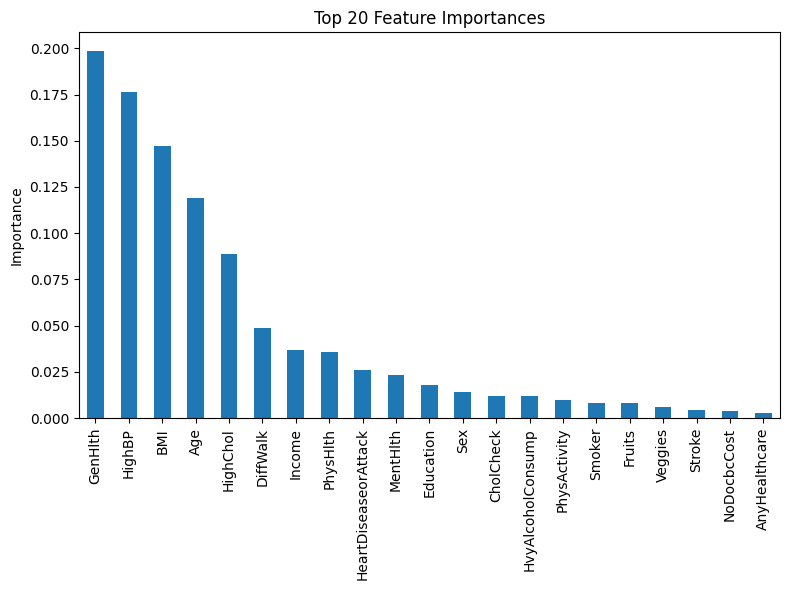

In [22]:
plt.figure(figsize=(8, 6))
feat_imp.plot.bar()
plt.title("Top 20 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## E_MT_RF_3: Random Forest mit originärem Datensatz

In [31]:
# RandomizedSearch 1
rf = RandomForestClassifier(bootstrap=True, random_state=42, n_jobs=-1)

param_grid5 = {
    'n_estimators': [300, 325, 350, 375, 400],
    'criterion': ['entropy', 'gini', 'log_loss'],
    'min_samples_split': [10, 15, 25, 35],
    'min_samples_leaf': [15, 20, 35],
    'max_depth': [15, 20, 30, 35],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [1200, 1300, 1400, 1500],
    'oob_score': [True, False]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = {"recall":make_scorer(recall_score, pos_label=1), "precision":make_scorer(precision_score, pos_label=1), "f1":make_scorer(f1_score, pos_label=1)}

r_search5 = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid5,
    cv=cv,
    n_jobs=-1,
    scoring=scoring,
    refit="f1",
    verbose=10,
    error_score='raise'
)

r_search5.fit(X_train, np.ravel(y_train))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'criterion': ['entropy', 'gini', ...], 'max_depth': [15, 20, ...], 'max_features': ['sqrt', 'log2'], 'max_leaf_nodes': [1200, 1300, ...], ...}"
,n_iter,10
,scoring,"{'f1': make_scorer(f..., pos_label=1), 'precision': make_scorer(p..., pos_label=1), 'recall': make_scorer(r..., pos_label=1)}"
,n_jobs,-1
,refit,'f1'
,cv,StratifiedKFo... shuffle=True)
,verbose,10
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,'raise'


In [32]:
print("Beste Parameter:", r_search5.best_params_)

Beste Parameter: {'oob_score': True, 'n_estimators': 400, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_leaf_nodes': 1500, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'gini'}


In [3]:
# Finale Modell
rf_model5 = RandomForestClassifier(
    n_estimators=400,
    criterion='gini',
    min_samples_split=15,
    min_samples_leaf=15,
    max_depth=15,
    max_features='log2',
    max_leaf_nodes=1500,
    oob_score=True,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf_model5.fit(X_train, np.ravel(y_train))

,n_estimators,400
,criterion,'gini'
,max_depth,15
,min_samples_split,15
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,1500
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [34]:
y_pred5 = rf_model5.predict(X_val)

print(classification_report(np.ravel(y_val), y_pred5))
print("Confusion Matrix:\n", confusion_matrix(np.ravel(y_val), y_pred5))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93     21833
           1       0.61      0.11      0.19      3535

    accuracy                           0.87     25368
   macro avg       0.74      0.55      0.56     25368
weighted avg       0.84      0.87      0.82     25368

Confusion Matrix:
 [[21582   251]
 [ 3138   397]]


In [4]:
y_pred5_test = rf_model5.predict(X_test)
y_probs5_test = rf_model5.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(np.ravel(y_test), y_probs5_test)
print(f"AUC-ROC: {auc_score:.4f}")

print(classification_report(np.ravel(y_test), y_pred5_test))
print("Confusion Matrix:\n", confusion_matrix(np.ravel(y_test), y_pred5_test))

AUC-ROC: 0.8248
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     43667
           1       0.59      0.11      0.19      7069

    accuracy                           0.87     50736
   macro avg       0.73      0.55      0.56     50736
weighted avg       0.83      0.87      0.82     50736

Confusion Matrix:
 [[43107   560]
 [ 6270   799]]


## Andere Experimente

In [36]:
cal_sigmoid = CalibratedClassifierCV(
    estimator=rf_model3,
    method='sigmoid',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

cal_iso = CalibratedClassifierCV(
    estimator=rf_model3,
    method='isotonic',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

cal_sigmoid.fit(X_train, np.ravel(y_train))
cal_iso.fit(X_train, np.ravel(y_train))

probs_val_sig = cal_sigmoid.predict_proba(X_val)[:, 1]
probs_val_iso = cal_iso.predict_proba(X_val)[:, 1]
probs_val_raw = rf_model5.fit(X_train, np.ravel(y_train)).predict_proba(X_val)[:, 1]

print("Brier Score (raw):    ", brier_score_loss(np.ravel(y_val), probs_val_raw))
print("Brier Score (sigmoid):", brier_score_loss(np.ravel(y_val), probs_val_sig))
print("Brier Score (isotonic):", brier_score_loss(np.ravel(y_val), probs_val_iso))

def tune_threshold(y_true, probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    f1s = 2 * precisions * recalls / (precisions + recalls + 1e-8)
    best = np.argmax(f1s[:-1])
    return thresholds[best], f1s[best]

th_raw, f1_raw = tune_threshold(np.ravel(y_val), probs_val_raw)
th_sig, f1_sig = tune_threshold(np.ravel(y_val), probs_val_sig)
th_iso, f1_iso = tune_threshold(np.ravel(y_val), probs_val_iso)

print(f"Raw   → Threshold={th_raw:.3f}, F1={f1_raw:.3f}")
print(f"Sigmoid → Threshold={th_sig:.3f}, F1={f1_sig:.3f}")
print(f"Isotonic→ Threshold={th_iso:.3f}, F1={f1_iso:.3f}")

Brier Score (raw):     0.09726611722197362
Brier Score (sigmoid): 0.09723452281245562
Brier Score (isotonic): 0.09708694231037185
Raw   → Threshold=0.227, F1=0.470
Sigmoid → Threshold=0.234, F1=0.472
Isotonic→ Threshold=0.256, F1=0.472


In [37]:
probs_val = rf_model3.predict_proba(X_val)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(np.ravel(y_val), probs_val)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Optimaler Threshold: {best_threshold:.3f}  →  Max. F1-Score: {best_f1:.3f}")

Optimaler Threshold: 0.512  →  Max. F1-Score: 0.472


In [40]:
y_pred_opt = (probs_val >= best_threshold).astype(int)
y_probs_opt = rf_model3.predict_proba(X_val)[:, 1]

auc_score = roc_auc_score(np.ravel(y_test), y_probs_test)
print(f"AUC-ROC: {auc_score:.4f}")

print(classification_report(y_val, y_pred_opt))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_opt))

AUC-ROC: 0.8109
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     21833
           1       0.39      0.61      0.47      3535

    accuracy                           0.81     25368
   macro avg       0.66      0.73      0.68     25368
weighted avg       0.85      0.81      0.83     25368

Confusion Matrix:
 [[18404  3429]
 [ 1386  2149]]


In [41]:
# Wahrscheinlichkeiten im Testset
probs_test = rf_model3.predict_proba(X_test)[:, 1]
y_test_opt = (probs_test >= best_threshold).astype(int)

auc_score = roc_auc_score(np.ravel(y_test), probs_test)
print(f"AUC-ROC: {auc_score:.4f}")

print(classification_report(y_test, y_test_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_opt))

AUC-ROC: 0.8247
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     43667
           1       0.38      0.60      0.47      7069

    accuracy                           0.81     50736
   macro avg       0.65      0.72      0.67     50736
weighted avg       0.85      0.81      0.83     50736

Confusion Matrix:
 [[36780  6887]
 [ 2837  4232]]


In [42]:
importances = rf_model3.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)
print("Feature Importances:")
for feature, importance in feat_imp.items():
    print(f"{feature}: {importance:.4f}")

Feature Importances:
GenHlth: 0.1987
HighBP: 0.1765
BMI: 0.1473
Age: 0.1191
HighChol: 0.0886
DiffWalk: 0.0489
Income: 0.0367
PhysHlth: 0.0359
HeartDiseaseorAttack: 0.0260
MentHlth: 0.0234
Education: 0.0178
Sex: 0.0139
CholCheck: 0.0122
HvyAlcoholConsump: 0.0119
PhysActivity: 0.0096
Smoker: 0.0084
Fruits: 0.0081
Veggies: 0.0060
Stroke: 0.0046
NoDocbcCost: 0.0037
AnyHealthcare: 0.0025


In [8]:
joblib.dump(rf_model3, 'rf.pkl')

['rf.pkl']

In [30]:
# Finale Modell
rf_model32 = RandomForestClassifier(
    n_estimators=350,
    criterion='entropy',
    min_samples_split=170,
    min_samples_leaf=50,
    max_depth=35,
    max_features='sqrt',
    max_leaf_nodes=1000,
    oob_score=False,
    bootstrap=True,
    class_weight={0:0.8, 1:3.85},
    random_state=42,
    n_jobs=-1
)
rf_model32.fit(X_train, np.ravel(y_train))

,n_estimators,350
,criterion,'entropy'
,max_depth,35
,min_samples_split,170
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,1000
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
y_pred32 = rf_model32.predict(X_val)

print(classification_report(np.ravel(y_val), y_pred32))
print("Confusion Matrix:\n", confusion_matrix(np.ravel(y_val), y_pred32))

              precision    recall  f1-score   support

           0       0.94      0.77      0.85     21833
           1       0.33      0.71      0.45      3535

    accuracy                           0.76     25368
   macro avg       0.64      0.74      0.65     25368
weighted avg       0.86      0.76      0.79     25368

Confusion Matrix:
 [[16788  5045]
 [ 1011  2524]]


In [32]:
y_pred32 = rf_model32.predict(X_test)

print(classification_report(np.ravel(y_test), y_pred32))
print("Confusion Matrix:\n", confusion_matrix(np.ravel(y_test), y_pred32))

              precision    recall  f1-score   support

           0       0.94      0.77      0.85     43667
           1       0.33      0.72      0.46      7069

    accuracy                           0.76     50736
   macro avg       0.64      0.74      0.65     50736
weighted avg       0.86      0.76      0.79     50736

Confusion Matrix:
 [[33572 10095]
 [ 1999  5070]]
